In [146]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
# import xlrd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
warnings.filterwarnings('ignore')

In [147]:
df = pd.read_csv("Shortage data/shortage_final.csv")

# converting headers in lowercase
df.columns = df.columns.str.lower()

# replacing spaces for "_" in headers
df.columns = df.columns.str.replace(' ', '_')

# Removing NaN actual_start_date and actual_end_date, considering as an incomplete record
df=df.dropna(subset=['actual_start_date','actual_end_date'] )

# Removing Actuals before 2017
df = df.loc[(df['actual_start_date'] >= '2017-01-01')]
# Removing outliers before 2010 for End_date
df = df.loc[(df['actual_end_date'] >= '2010-01-01')]

# Removing duplicates ID Reports
df=df.drop_duplicates("report_id", keep=False)

df.tail()

,report_id,drug_identification_number,report_type,brand_name,company_name,common_or_proper_name,ingredients,strength(s),packaging_size,route_of_administration,...,atc_code,atc_description,anticipated_start_date,actual_start_date,estimated_end_date,actual_end_date,reason,date_created,date_updated,tier_3
17163,21685,2340445.0,Shortage,ZYCLARA,VALEANT CANADA LP/VALEANT CANADA S.E.C.,ZYCLARA,IMIQUIMOD,3.75%,na,TOPICAL,...,D06BB,CHEMOTHERAPEUTICS FOR TOPICAL USE,NaN,2017-09-08,2017-09-22,2017-09-22,Other (Please describe in comments),2017-09-08,2017-09-25,No
17164,52702,2340445.0,Shortage,ZYCLARA,VALEANT CANADA LP/VALEANT CANADA S.E.C.,ZYCLARA,IMIQUIMOD,3.75%,7.5g pump,TOPICAL,...,D06BB,CHEMOTHERAPEUTICS FOR TOPICAL USE,NaN,2019-04-01,NaN,2019-07-12,Other (Please describe in comments),2018-06-20,2019-07-13,No
17165,18241,2257270.0,Shortage,ZYMAR,ALLERGAN INC,ZYMAR 1mL,GATIFLOXACIN,0.3%,1 mL,OPHTHALMIC,...,S01AE,ANTIINFECTIVES,2017-08-03,2017-08-03,2017-09-18,2017-10-06,Disruption of the manufacture of the drug.,2017-08-03,2017-10-13,No
17166,33440,2257270.0,Shortage,ZYMAR,ALLERGAN INC,ZYMAR 1mL,GATIFLOXACIN,0.3%,5mL,OPHTHALMIC,...,S01AE,ANTIINFECTIVES,2019-09-16,2019-09-16,2019-09-20,2019-09-18,Disruption of the manufacture of the drug.,2017-12-18,2019-09-19,No
17167,54338,2243686.0,Shortage,ZYVOXAM,PFIZER CANADA INC,Zyvoxam,LINEZOLID,3G,1x240ml Btl,ORAL,...,J01XX,OTHER ANTIBACTERIALS,NaN,2018-08-21,NaN,2018-10-23,Disruption of the manufacture of the drug.,2018-07-04,2018-10-24,No


In [148]:
df['actual_start_date'] = df['actual_start_date'].astype('datetime64[D]')
df['actual_end_date'] = df['actual_end_date'].astype('datetime64[D]')

In [149]:
df['drug_identification_number'] = df['drug_identification_number'].fillna(0)
df['drug_identification_number'] = df['drug_identification_number'].astype('int')

In [150]:
df=df.drop_duplicates("report_id", keep=False)

In [151]:
df['Days']= df['actual_end_date']-df['actual_start_date']

In [152]:
df['Days2'] = df['Days'].dt.days
df['Days2']=df['Days2'].astype('int')

In [153]:
df= df[(df['Days2']>0)]

In [154]:
print ("Unique values:  \n",df.nunique())

Unique values:  
 report_id                     13332
drug_identification_number     5391
report_type                       1
brand_name                     3395
company_name                    195
common_or_proper_name          4551
ingredients                    1169
strength(s)                     868
packaging_size                 2403
route_of_administration         178
shortage_status                   3
dosage_form(s)                  122
atc_code                        462
atc_description                 201
anticipated_start_date         1252
actual_start_date              1704
estimated_end_date             1597
actual_end_date                1670
reason                            7
date_created                   1516
date_updated                   1797
tier_3                            2
Days                            816
Days2                           816
dtype: int64


In [155]:
# Separating catagorical and numerical columns
Id_col     = ['report_id']
target_col = ["Days2"]
cat_cols   = df.keys().tolist()

In [156]:
cat_cols

['report_id',
 'drug_identification_number',
 'report_type',
 'brand_name',
 'company_name',
 'common_or_proper_name',
 'ingredients',
 'strength(s)',
 'packaging_size',
 'route_of_administration',
 'shortage_status',
 'dosage_form(s)',
 'atc_code',
 'atc_description',
 'anticipated_start_date',
 'actual_start_date',
 'estimated_end_date',
 'actual_end_date',
 'reason',
 'date_created',
 'date_updated',
 'tier_3',
 'Days',
 'Days2']

In [157]:
cat_cols   = df.nunique()[df.nunique() < 6].keys().tolist()

In [158]:
cat_cols   = [x for x in cat_cols if x not in target_col]
num_cols   = [x for x in df.columns if x not in cat_cols + target_col + Id_col]

In [159]:
Id_col

['report_id']

In [160]:
num_cols

['drug_identification_number',
 'brand_name',
 'company_name',
 'common_or_proper_name',
 'ingredients',
 'strength(s)',
 'packaging_size',
 'route_of_administration',
 'dosage_form(s)',
 'atc_code',
 'atc_description',
 'anticipated_start_date',
 'actual_start_date',
 'estimated_end_date',
 'actual_end_date',
 'reason',
 'date_created',
 'date_updated',
 'Days']

<AxesSubplot:xlabel='actual_start_date', ylabel='Days2'>

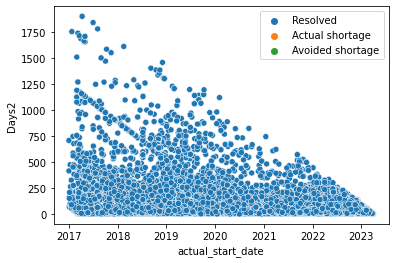

In [161]:
# Create a scatter plot of time and # of Days
sns.scatterplot(data = df, x =df['actual_start_date'],
                               y = df['Days2'],
                               hue=df.shortage_status.tolist())

<AxesSubplot:xlabel='shortage_status', ylabel='Days2'>

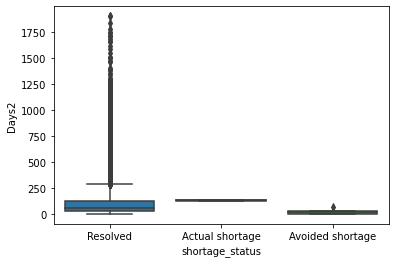

In [162]:
sns.boxplot(data = df,
                x =df['shortage_status'],
                y = df['Days2'])

In [163]:
df.common_or_proper_name.value_counts()


ROSUVASTATIN                       127
CANDESARTAN                         87
OLANZAPINE                          87
PREGABALIN                          79
RAMIPRIL                            79
                                  ... 
TEVA-CLINDAMYCIN 150MG CAPSULES      1
CLOBAZAM 10MG TAB                    1
TEVA-CLOBETASOL                      1
TEVA-CLOBETASOL 0.05% OINTMENT       1
Zyvoxam                              1
Name: common_or_proper_name, Length: 4551, dtype: int64

In [164]:
df.drug_identification_number.value_counts()

717002     28
60208      22
60348      21
2293838    18
2245523    18
           ..
2422549     1
2351102     1
2351110     1
2248416     1
2293528     1
Name: drug_identification_number, Length: 5391, dtype: int64

In [165]:
df2 = df[df.common_or_proper_name=='ROSUVASTATIN']

In [166]:
df2.shape

(127, 24)

array([[<AxesSubplot:title={'center':'Days2'}>]], dtype=object)

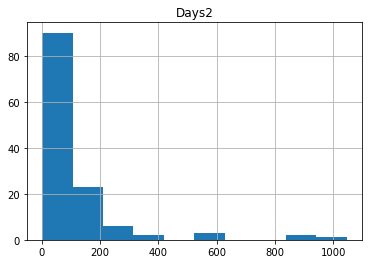

In [167]:
df2.hist(column='Days2')

<AxesSubplot:title={'center':'Days Distribution'}, ylabel='# of Days'>

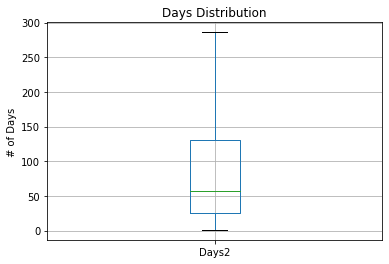

In [168]:
# Create a box plot to identify outliers

Boxplot, bp=plt.subplots()
# bp.set_xlabel('Days')
bp.set_ylabel('# of Days')
bp.set_title('Days Distribution')
bp.grid()
df.boxplot(column="Days2", showfliers=False)

In [169]:
col_list = ['actual_start_date', 'Days2']

In [170]:
df2 = df2[col_list]

In [171]:
df2.columns = ['ds', 'y']

In [172]:
df2.shape

(127, 2)

In [173]:
m = Prophet()
m.fit(df2)


18:18:50 - cmdstanpy - INFO - Chain [1] start processing
18:18:51 - cmdstanpy - INFO - Chain [1] done processing


In [174]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
457,2024-02-20
458,2024-02-21
459,2024-02-22
460,2024-02-23
461,2024-02-24


In [175]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
457,2024-02-20,-29.934312,-207.158583,153.713547
458,2024-02-21,-64.117403,-240.524309,119.071798
459,2024-02-22,29.235289,-158.781262,208.146065
460,2024-02-23,-28.053662,-202.363537,161.012412
461,2024-02-24,5.963648,-189.439705,184.849747


Text(51.5, 0.5, 'Days of Shortage')

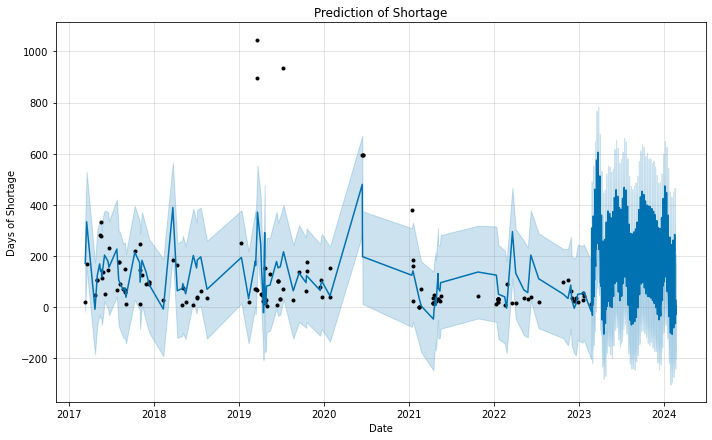

In [176]:
fig1 = m.plot(forecast)
plt.title("Prediction of Shortage")
plt.xlabel("Date")
plt.ylabel("Days of Shortage")

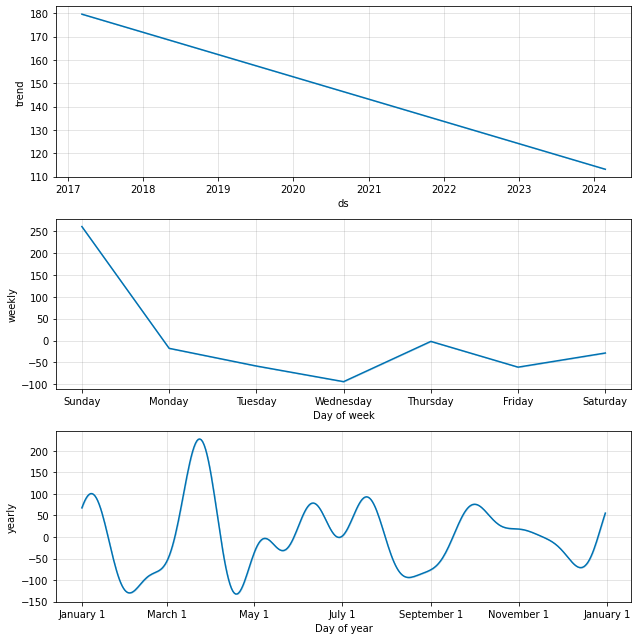

In [177]:
fig2 = m.plot_components(forecast)

Zoom in into predicted values

In [178]:
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)